# Preamble

In [1]:
%run -i scripts/preamble.py

# Introduction

As outlined in the Feasibility secition of my Milestone 3 submission, I have segmented the work over the next few weeks according to the following timeline

![](figures/timeline.png)

Below I proceed by structuring my response according to the following sections
- Model Specific Research
- Data exploration, preprocessing and environment setup
- Model Replication and Experimentation

# Model Specific Research

*__Fill out details from readings__*

On the basis of my reasearch and published results, I have chosen to investigate the following models:

__Shallow__
- Logistic Regression
- Factorization Machines

__Deep__
- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

# Data Exploration, preprocessing and environment setup

## Exploratory Data Analysis

/tmp/ipykernel_25209/1746979306.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticks(),rotation=45)
/tmp/ipykernel_25209/1746979306.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks(),rotation=45)
/tmp/ipykernel_25209/1746979306.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticks(),rotation=45)


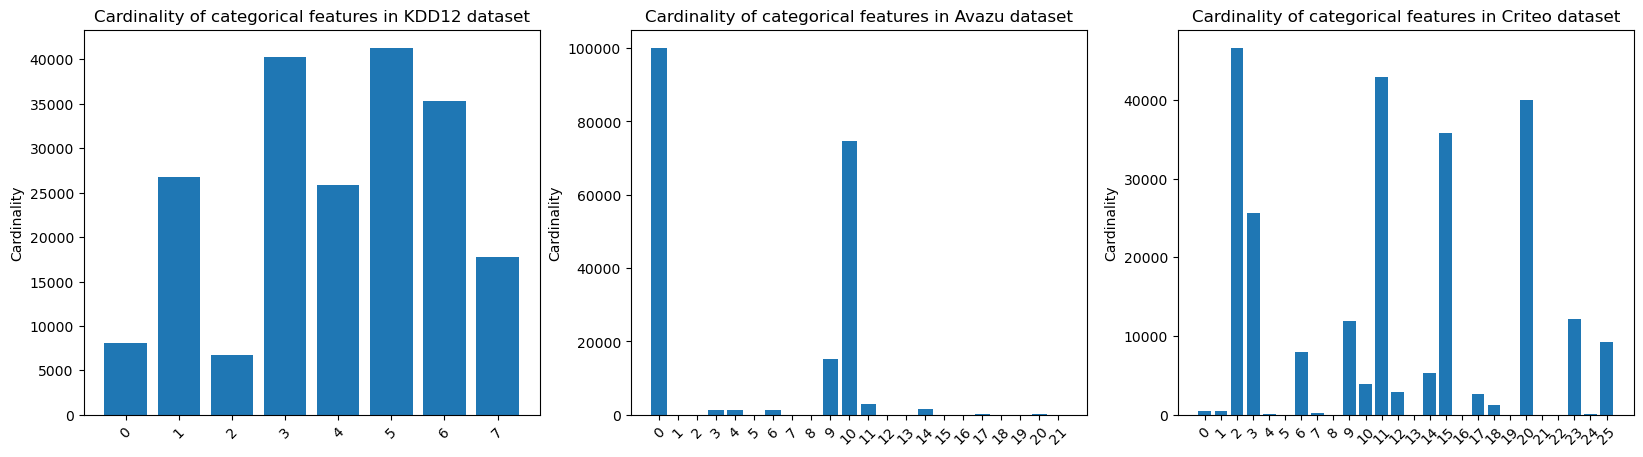

## Preprocessing

# Model Replication and Experimentation

In [2]:
%run -i scripts/modelling/load_and_prep_data.py

## Shallow Models

In order to attain representitive results from beyond the realm of deep learning, below I evaluate two of the most poplarly used shallow models for CTR prediction:

- Logistic regression
- Factorization machines

### Logistic Regression

In [3]:
%run -i scripts/modelling/fit_lr_models.py
%run -i scripts/modelling/score_lr_models.py
%run -i scripts/modelling/save_lr_models.py

KDD12:
Log loss: 0.162493229115702
ROC AUC: 0.69918173566772
Accuracy: 0.95825

Avazu:
Log loss: 0.41220123857803254
ROC AUC: 0.7187724509322894
Accuracy: 0.83205

Criteo:
Log loss: 0.4926044086201233
ROC AUC: 0.7461917357547045
Accuracy: 0.76775


### Factorization Machine

In [4]:
%run -i scripts/modelling/fit_fm_models.py
%run -i scripts/modelling/score_fm_models.py
%run -i scripts/modelling/save_fm_models.py

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 26.85071959222282
ROC AUC: 0.5000335570469798
Accuracy: 0.25505


## Deep Models

As explained above, I will be exploring the following deep models:

- Factorization Supported Neural Networks
- Product Based Neural Networks
- Wide and Deep
- DeepFM
- Feature Generation by Convolutional Neural Networks
- Automatic Feature Interaction (AutoInt)

### Factorization-Machine Supported Neural Networks

In [8]:
# Compile the models
kdd12_fnn_model = FNN(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_fnn_model = FNN(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_fnn_model = FNN(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_fnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

2024-07-13 18:57:28.421029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-13 18:57:28.422928: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 18:57:28.424892: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
# Fit the models
kdd12_fnn_history = kdd12_fnn_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
avazu_fnn_history = avazu_fnn_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
criteo_fnn_history = criteo_fnn_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

2024-07-13 18:57:31.786071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-13 18:57:31.794952: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10
250/250 - 7s - loss: 0.2078 - binary_crossentropy: 0.2077 - val_loss: 0.1727 - val_binary_crossentropy: 0.1725
Epoch 2/10
250/250 - 3s - loss: 0.1694 - binary_crossentropy: 0.1691 - val_loss: 0.1714 - val_binary_crossentropy: 0.1711
Epoch 3/10
250/250 - 3s - loss: 0.1668 - binary_crossentropy: 0.1664 - val_loss: 0.1735 - val_binary_crossentropy: 0.1730
Epoch 4/10
250/250 - 3s - loss: 0.1662 - binary_crossentropy: 0.1656 - val_loss: 0.1724 - val_binary_crossentropy: 0.1718
Epoch 5/10
250/250 - 4s - loss: 0.1652 - binary_crossentropy: 0.1646 - val_loss: 0.1738 - val_binary_crossentropy: 0.1732
Epoch 6/10
250/250 - 3s - loss: 0.1644 - binary_crossentropy: 0.1638 - val_loss: 0.1741 - val_binary_crossentropy: 0.1734
Epoch 7/10
250/250 - 3s - loss: 0.1637 - binary_crossentropy: 0.1630 - val_loss: 0.1743 - val_binary_crossentropy: 0.1736
Epoch 8/10
250/250 - 3s - loss: 0.1630 - binary_crossentropy: 0.1623 - val_loss: 0.1733 - val_binary_crossentropy: 0.1726
Epoch 9/10
250/250 - 3s 

In [10]:
# Save the models
kdd12_fnn_model.save('models/fnn/kdd12_fnn_model.keras')
avazu_fnn_model.save('models/fnn/avazu_fnn_model.keras')
criteo_fnn_model.save('models/fnn/criteo_fnn_model.keras')

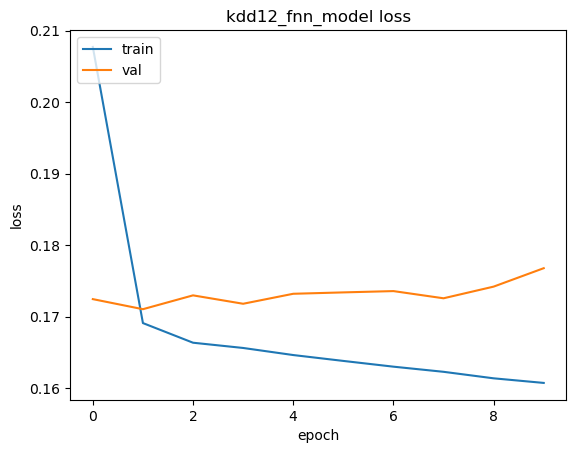

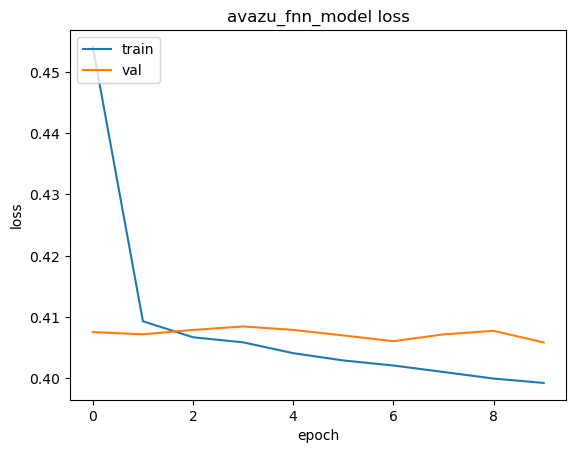

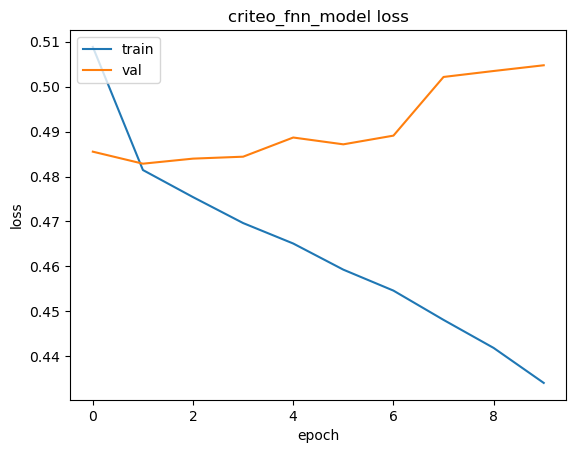

In [11]:
# Plot the training history
plt.plot(kdd12_fnn_history.history['binary_crossentropy'])
plt.plot(kdd12_fnn_history.history['val_binary_crossentropy'])
plt.title('kdd12_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_fnn_history.history['binary_crossentropy'])
plt.plot(avazu_fnn_history.history['val_binary_crossentropy'])
plt.title('avazu_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_fnn_history.history['binary_crossentropy'])
plt.plot(criteo_fnn_history.history['val_binary_crossentropy'])
plt.title('criteo_fnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Score the models
kdd12_fnn_score = kdd12_fnn_model.evaluate(kdd12_test_model_input, kdd12_val_y, batch_size=256)
avazu_fnn_score = avazu_fnn_model.evaluate(avazu_test_model_input, avazu_val_y, batch_size=256)
criteo_fnn_score = criteo_fnn_model.evaluate(criteo_test_model_input, criteo_val_y, batch_size=256)

79/79 [==============================] - 1s 10ms/step - loss: 0.5056 - binary_crossentropy: 0.5050


### Product Based Neural Networks

In [14]:
# Compile the PNN models
kdd12_pnn_model = PNN(kdd12_dnn_feature_columns, task='binary')
kdd12_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_pnn_model = PNN(avazu_dnn_feature_columns, task='binary')
avazu_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_pnn_model = PNN(criteo_dnn_feature_columns, task='binary')
criteo_pnn_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [ ]:
# Fit the models
kdd12_pnn_history = kdd12_pnn_model.fit(kdd12_train_model_input, kdd12_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
avazu_pnn_history = avazu_pnn_model.fit(avazu_train_model_input, avazu_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
criteo_pnn_history = criteo_pnn_model.fit(criteo_train_model_input, criteo_train_y, batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10
250/250 - 6s - loss: 0.2018 - binary_crossentropy: 0.2018 - val_loss: 0.1731 - val_binary_crossentropy: 0.1729
Epoch 2/10
250/250 - 3s - loss: 0.1690 - binary_crossentropy: 0.1688 - val_loss: 0.1711 - val_binary_crossentropy: 0.1707
Epoch 3/10
250/250 - 3s - loss: 0.1666 - binary_crossentropy: 0.1662 - val_loss: 0.1724 - val_binary_crossentropy: 0.1720
Epoch 4/10
250/250 - 3s - loss: 0.1658 - binary_crossentropy: 0.1653 - val_loss: 0.1731 - val_binary_crossentropy: 0.1725
Epoch 5/10
250/250 - 3s - loss: 0.1652 - binary_crossentropy: 0.1646 - val_loss: 0.1737 - val_binary_crossentropy: 0.1732
Epoch 6/10
250/250 - 3s - loss: 0.1649 - binary_crossentropy: 0.1643 - val_loss: 0.1758 - val_binary_crossentropy: 0.1752
Epoch 7/10
250/250 - 3s - loss: 0.1647 - binary_crossentropy: 0.1641 - val_loss: 0.1730 - val_binary_crossentropy: 0.1724
Epoch 8/10
250/250 - 3s - loss: 0.1644 - binary_crossentropy: 0.1637 - val_loss: 0.1731 - val_binary_crossentropy: 0.1725
Epoch 9/10
250/250 - 3s 

In [ ]:
# Save the models
kdd12_pnn_model.save('models/pnn/kdd12_pnn_model.keras')
avazu_pnn_model.save('models/pnn/avazu_pnn_model.keras')
criteo_pnn_model.save('models/pnn/criteo_pnn_model.keras')

In [ ]:
# Plot the training history
plt.plot(kdd12_pnn_history.history['binary_crossentropy'])
plt.plot(kdd12_pnn_history.history['val_binary_crossentropy'])
plt.title('kdd12_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(avazu_pnn_history.history['binary_crossentropy'])
plt.plot(avazu_pnn_history.history['val_binary_crossentropy'])
plt.title('avazu_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(criteo_pnn_history.history['binary_crossentropy'])
plt.plot(criteo_pnn_history.history['val_binary_crossentropy'])
plt.title('criteo_pnn_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Wide and Deep

In [ ]:
# Compile the WDL models
kdd12_wdl_model = WDL(kdd12_linear_feature_columns, kdd12_dnn_feature_columns, task='binary')
kdd12_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

avazu_wdl_model = WDL(avazu_linear_feature_columns, avazu_dnn_feature_columns, task='binary')
avazu_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

criteo_wdl_model = WDL(criteo_linear_feature_columns, criteo_dnn_feature_columns, task='binary')
criteo_wdl_model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [ ]:
# Fit the Wide and Deep models
